# **CITY BIKE API**

### **ABOUT CITY BIKE API**

The city bike API is a  project that provides bike sharing data for apps, research and projects to use. To date Citybikes supports more than 400 cities and the Citybikes API is the most widely used dataset for building bike sharing transportation projects.

In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# API url
url = "http://api.citybik.es/v2/networks"

In [4]:
# parsed the data as JSON
response = requests.get(url).json()
# prints first 5 values
response['networks'][:5]

[{'company': ['ЗАО «СитиБайк»'],
  'href': '/v2/networks/velobike-moscow',
  'id': 'velobike-moscow',
  'location': {'city': 'Moscow',
   'country': 'RU',
   'latitude': 55.75,
   'longitude': 37.616667},
  'name': 'Velobike'},
 {'company': ['Comunicare S.r.l.'],
  'href': '/v2/networks/bicincitta-siena',
  'id': 'bicincitta-siena',
  'location': {'city': 'Siena',
   'country': 'IT',
   'latitude': 43.3186,
   'longitude': 11.3306},
  'name': 'Bicincittà',
  'source': 'https://www.bicincitta.com/frmLeStazioni.aspx?ID=202'},
 {'company': ['Cyclopolis Systems'],
  'href': '/v2/networks/cyclopolis-maroussi',
  'id': 'cyclopolis-maroussi',
  'location': {'city': 'Maroussi',
   'country': 'GR',
   'latitude': 38.0568722388,
   'longitude': 23.8083299536},
  'name': 'Cyclopolis'},
 {'company': ['Cyclopolis Systems'],
  'href': '/v2/networks/cyclopolis-nafplio',
  'id': 'cyclopolis-nafplio',
  'location': {'city': 'Nafplio',
   'country': 'GR',
   'latitude': 37.5639397319,
   'longitude': 22

> From the documentation, the API provides field filtering parameter and from the list of features in the JSON formatted data, I am interested in the name of the company providing the bike and the location of the company.

In [5]:
# API url with the filter parameter
urlFilter = "http://api.citybik.es/v2/networks?fields=name,location"

In [6]:
# parsed the data as JSON
responseFilter = requests.get(urlFilter).json()
# prints first 5 values
responseFilter['networks'][:5]

[{'location': {'city': 'Moscow',
   'country': 'RU',
   'latitude': 55.75,
   'longitude': 37.616667},
  'name': 'Velobike'},
 {'location': {'city': 'Siena',
   'country': 'IT',
   'latitude': 43.3186,
   'longitude': 11.3306},
  'name': 'Bicincittà'},
 {'location': {'city': 'Maroussi',
   'country': 'GR',
   'latitude': 38.0568722388,
   'longitude': 23.8083299536},
  'name': 'Cyclopolis'},
 {'location': {'city': 'Nafplio',
   'country': 'GR',
   'latitude': 37.5639397319,
   'longitude': 22.8093402872},
  'name': 'Cyclopolis'},
 {'location': {'city': 'Parco dei Colli di Bergamo',
   'country': 'IT',
   'latitude': 45.72295637032245,
   'longitude': 9.649230073016383},
  'name': 'Bicincittà'}]

> The result above shows that location information is stored in a dictionary.

## **PUT INFORMATION INTO A TABLE**

In [7]:
# create main dataframe
bikeData = pd.DataFrame()

# loop through the JSON formatted data
for i in range(len(responseFilter['networks'])):
    # create a temporary dataframe
    temp = pd.DataFrame(
        {
            'Name': [responseFilter['networks'][i]['name']],
            'Country': [responseFilter['networks'][i]['location']['country']],
            'City': [responseFilter['networks'][i]['location']['city']],
            'Latitude': [responseFilter['networks'][i]['location']['latitude']],
            'Longitude': [responseFilter['networks'][i]['location']['longitude']]
        }
    )

    # concatenate the temporary dataframe with the earlier created dataframe
    bikeData = pd.concat([bikeData, temp], ignore_index=True)

bikeData.head()

,Name,Country,City,Latitude,Longitude
0,Velobike,RU,Moscow,55.750000,37.616667
1,Bicincittà,IT,Siena,43.318600,11.330600
2,Cyclopolis,GR,Maroussi,38.056872,23.808330
3,Cyclopolis,GR,Nafplio,37.563940,22.809340
4,Bicincittà,IT,Parco dei Colli di Bergamo,45.722956,9.649230


## **EXPLORATORY DATA ANALYSIS**

In [8]:
bikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       770 non-null    object 
 1   Country    770 non-null    object 
 2   City       770 non-null    object 
 3   Latitude   770 non-null    float64
 4   Longitude  770 non-null    float64
dtypes: float64(2), object(3)
memory usage: 30.2+ KB


> The result shows there are 770 rows and 5 features, no missing values, also the datatype of each feature appears to be appropriate.

#### **HOW MANY UNIQUE COUNTRIES AND CITIES ARE IN THE DATAFRAME?**

In [9]:
bikeData['Country'].nunique()

57

In [10]:
bikeData['City'].nunique()

750

> The outputs from the above cells tells that some countries and cities occurred more than once in the DataFrame, it would be a great idea to check for duplicates in the dataset so it doesn't affect the outcome of the analysis.

#### **CHECK FOR DUPLICATES IN THE DATASET**

In [11]:
bikeData.duplicated().sum()

0

> Even though the dataset have some countries and cities repeated, the result shows that there are no duplicate datapoint in the dataset.

## **DATA VISUALIZATION**

> Exploring the data as visuals

In [12]:
# sort values in ascending order and gets the index
country_count = bikeData['Country'].value_counts().index 

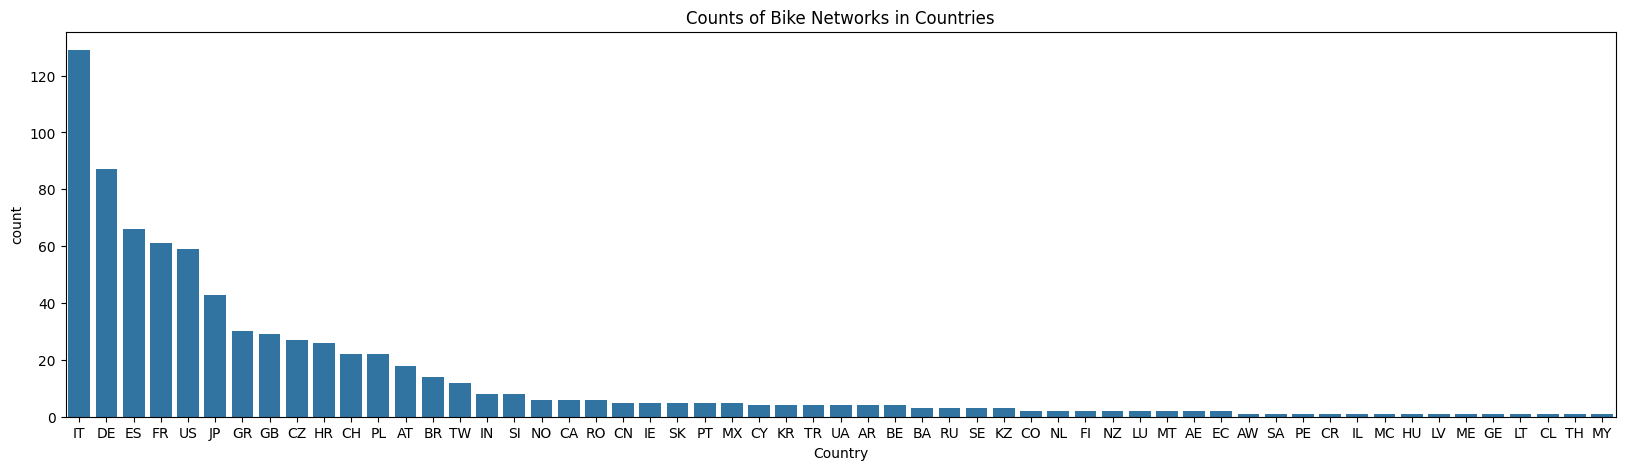

In [13]:
plt.figure(figsize=(20, 5)) # changes the figure size
sns.countplot(data=bikeData, x=bikeData['Country'], order=country_count);

plt.title('Counts of Bike Networks in Countries');

> Italy have the highest number of bike networks in the world according to the data from the API.

### **TOP 10 COUNTRIES WITH BIKE NETWORKS**

In [14]:
top10countries = bikeData.groupby('Country').count().sort_values(by='Name', ascending=False)\
                    .reset_index()[:10]

In [15]:
top10countries

,Country,Name,City,Latitude,Longitude
0,IT,129,129,129,129
1,DE,87,87,87,87
2,ES,66,66,66,66
3,FR,61,61,61,61
4,US,59,59,59,59
5,JP,43,43,43,43
6,GR,30,30,30,30
7,GB,29,29,29,29
8,CZ,27,27,27,27
9,HR,26,26,26,26


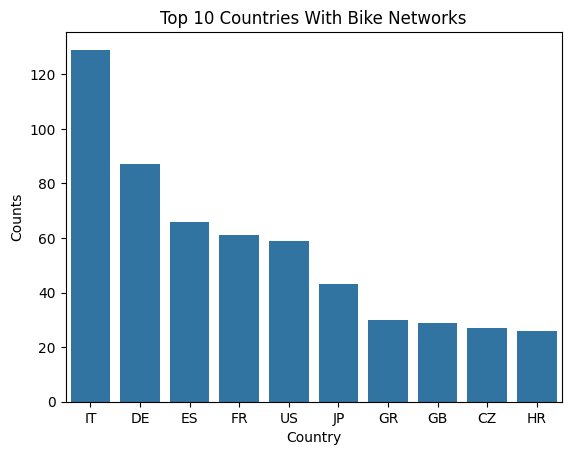

In [16]:
sns.barplot(data=top10countries, x=top10countries['Country'], y=top10countries['Name']);
plt.title('Top 10 Countries With Bike Networks');
plt.ylabel('Counts');

> The top ten countries with bike networks are Italy, Germany, Spain, France, United States, Japan, Greece, United Kingdom, Czech Republic, Croatia.

# **LOOKING INTO A PARTICULAR COMPANY**

> I will be looking into companies in the US for this analysis.

In [17]:
bikeData.query('Country == "US"').head(7)

,Name,Country,City,Latitude,Longitude
27,WE-cycle,US,"Aspen, CO",39.194951,-106.837002
77,ATX MetroBike,US,"Austin, TX",30.264080,-97.743550
78,Bike Chattanooga,US,"Chattanooga, TN",35.045630,-85.309680
81,BIKETOWN,US,"Portland, OR",45.521754,-122.681079
83,Boulder BCycle,US,"Boulder, CO",40.008110,-105.263850
85,Broward BCycle,US,"Fort Lauderdale, FL",26.120260,-80.148190
86,Bublr Bikes,US,"Milwaukee, WI",43.036900,-87.896670


> I will be using the _Bubler Bikes_ bike sharing network for my analysis, before that I need the network's id.

In [18]:
response['networks'][86]

{'company': ['BCycle, LLC'],
 'gbfs_href': 'https://gbfs.bcycle.com/bcycle_bublr/gbfs.json',
 'href': '/v2/networks/bublr-bikes',
 'id': 'bublr-bikes',
 'location': {'city': 'Milwaukee, WI',
  'country': 'US',
  'latitude': 43.0369,
  'longitude': -87.89667},
 'name': 'Bublr Bikes'}

## **BUBLR BIKE NETWORK**

In [19]:
# the Bublr Bike Network url
BBurl = "http://api.citybik.es/v2/networks/bublr-bikes"

In [20]:
BBdata = requests.get(BBurl).json()
BBdata

{'network': {'company': ['BCycle, LLC'],
  'gbfs_href': 'https://gbfs.bcycle.com/bcycle_bublr/gbfs.json',
  'href': '/v2/networks/bublr-bikes',
  'id': 'bublr-bikes',
  'location': {'city': 'Milwaukee, WI',
   'country': 'US',
   'latitude': 43.0369,
   'longitude': -87.89667},
  'name': 'Bublr Bikes',
  'stations': [{'empty_slots': 12,
    'extra': {'address': '1420 N. Marshall St.',
     'ebikes': 0,
     'has_ebikes': True,
     'last_updated': 1712603327,
     'normal_bikes': 3,
     'rental_uris': {'android': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=android',
      'ios': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=iOS'},
     'renting': 1,
     'returning': 1,
     'uid': 'bcycle_bublr_3326'},
    'free_bikes': 3,
    'id': '4b562f25ad06507ac8ab4b8a118b0f24',
    'latitude': 43.0482,
    'longitude': -87.90086,
    'name': 'Ogden & Marshall',
    'timestamp': '2024-04-08T19:09:17.

In [21]:
# gets the first station of the Bublr Bike Network
BBdata['network']['stations'][0]

{'empty_slots': 12,
 'extra': {'address': '1420 N. Marshall St.',
  'ebikes': 0,
  'has_ebikes': True,
  'last_updated': 1712603327,
  'normal_bikes': 3,
  'rental_uris': {'android': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=android',
   'ios': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=iOS'},
  'renting': 1,
  'returning': 1,
  'uid': 'bcycle_bublr_3326'},
 'free_bikes': 3,
 'id': '4b562f25ad06507ac8ab4b8a118b0f24',
 'latitude': 43.0482,
 'longitude': -87.90086,
 'name': 'Ogden & Marshall',
 'timestamp': '2024-04-08T19:09:17.657000Z'}

> What each keys in the network represents:

- empty_slots: The number of docks available for returning bikes.
- extra: Contains miscellaneous additional information, often including the station’s address.
- ebikes: The count of electric bikes available at the station.
- has_ebikes: A boolean (true/false) indicating if there are electric bikes at the station.
- last_updated: The Unix timestamp for when the station’s information was last updated.
- normal_bikes: The number of standard, non-electric bikes available.
- rental_uris: URLs for mobile applications to rent bikes.
- renting: A boolean indicating if the station is currently allowing rentals.
- returning: A boolean indicating if bikes can be returned at the moment.
- uid: A unique identifier for the station.
- free_bikes: The total number of bikes available for rent, including electric ones.
- id: Another identifier for the station, possibly internal.
- latitude and longitude: The geographical coordinates of the station.
- name: The name of the station.
- timestamp: The Unix timestamp for when this data snapshot was taken.

## **FEATURE ENGINEERING**

> Since some of the data in the dictionary are repeated, I will only be using a few of the values in the dictionary, these values includes:

- uid
- empty_slots
- ebikes
- has_ebikes
- normal_bikes
- renting
- returning
- latitude
- longitude
- free_bikes

Using the latitude and longitude again because the geographical coordinates of the stations differ from each other.

In [22]:
# main DataFrame to hold collected data
BBframe = pd.DataFrame()

# loop through the stations
for i in range(len(BBdata['network']['stations'])):
    # creates a temporaty DataFrame
    temp = pd.DataFrame(
        {
           'uid': [BBdata['network']['stations'][i]['extra']['uid']],
           'empty_slots': [BBdata['network']['stations'][i]['empty_slots']],
           'ebikes': [BBdata['network']['stations'][i]['extra']['ebikes']],
           'has_ebikes': [BBdata['network']['stations'][i]['extra']['has_ebikes']],
           'normal_bikes': [BBdata['network']['stations'][i]['extra']['normal_bikes']],
           'renting': [BBdata['network']['stations'][i]['extra']['renting']],
           'returning': [BBdata['network']['stations'][i]['extra']['returning']],
           'latitude': [BBdata['network']['stations'][i]['latitude']],
           'longitude': [BBdata['network']['stations'][i]['longitude']],
           'free_bikes': [BBdata['network']['stations'][i]['free_bikes']]
        }
    )
    # combines both the main and temporary DataFrame
    BBframe = pd.concat([BBframe, temp], ignore_index=True)

## **LOAD DATAFRAME**

In [23]:
BBframe.head()

,uid,empty_slots,ebikes,has_ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
0,bcycle_bublr_3326,12,0,True,3,1,1,43.04820,-87.90086,3
1,bcycle_bublr_3327,10,0,True,5,1,1,43.03865,-87.92193,5
2,bcycle_bublr_3489,11,1,True,1,1,1,43.04782,-87.89565,2
3,bcycle_bublr_3325,8,1,True,6,1,1,43.04824,-87.90497,7
4,bcycle_bublr_3322,3,1,True,11,1,1,43.02871,-87.90410,12


In [24]:
BBframe.to_csv('BBdata.csv')

## **EXPLORATORY DATA ANALYSIS**

In [25]:
BBframe.shape

(117, 10)

In [26]:
BBframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           117 non-null    object 
 1   empty_slots   117 non-null    int64  
 2   ebikes        117 non-null    int64  
 3   has_ebikes    117 non-null    bool   
 4   normal_bikes  117 non-null    int64  
 5   renting       117 non-null    int64  
 6   returning     117 non-null    int64  
 7   latitude      117 non-null    float64
 8   longitude     117 non-null    float64
 9   free_bikes    117 non-null    int64  
dtypes: bool(1), float64(2), int64(6), object(1)
memory usage: 8.5+ KB


In [27]:
BBframe.describe()

,empty_slots,ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,7.726496,1.051282,4.051282,0.991453,0.991453,43.044118,-87.936371,5.102564
std,3.659244,1.209489,3.016753,0.092450,0.092450,0.018257,0.046122,3.155140
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.993390,-88.043410,0.000000
25%,5.000000,0.000000,2.000000,1.000000,1.000000,43.031480,-87.976150,3.000000
50%,8.000000,1.000000,3.000000,1.000000,1.000000,43.045620,-87.916910,4.000000
75%,10.000000,2.000000,6.000000,1.000000,1.000000,43.057400,-87.904100,7.000000
max,20.000000,5.000000,14.000000,1.000000,1.000000,43.100150,-87.877300,17.000000


## **DATA VISUALIZATION**

> Distribution of the numerical features of the dataset.

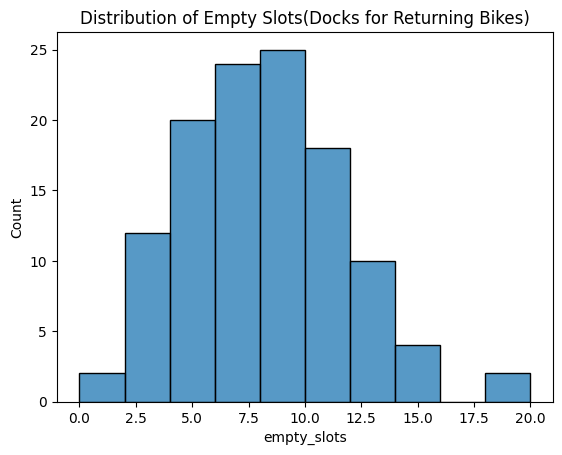

In [28]:
sns.histplot(data=BBframe, x=BBframe['empty_slots']);
plt.title('Distribution of Empty Slots(Docks for Returning Bikes)');

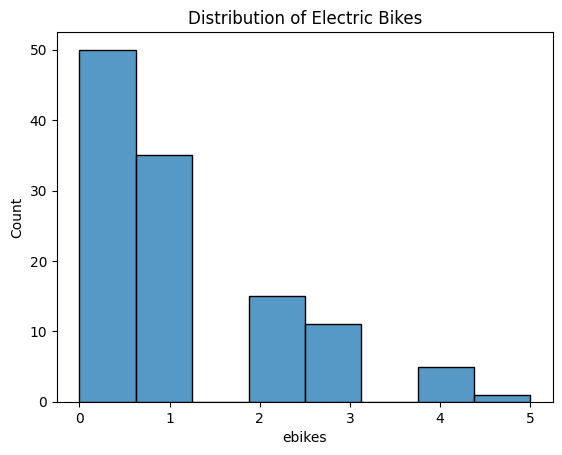

In [29]:
sns.histplot(data=BBframe, x=BBframe['ebikes']);
plt.title('Distribution of Electric Bikes');

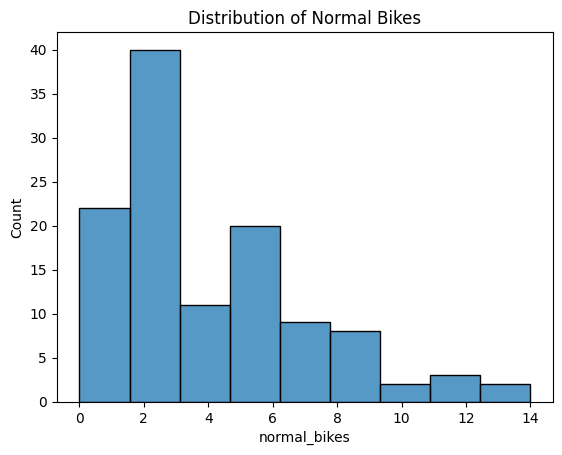

In [30]:
sns.histplot(data=BBframe, x=BBframe['normal_bikes']);
plt.title('Distribution of Normal Bikes');

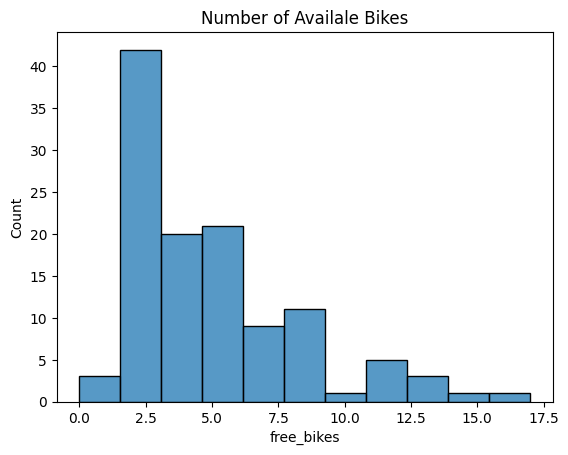

In [31]:
sns.histplot(data=BBframe, x=BBframe['free_bikes']);
plt.title('Number of Availale Bikes');

## **MODEL BUILDING**

> I would build a linear regression model for this project, the project would predict the total number of *free_bikes* available for rent, including the electric ones.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [33]:
BBframe.head(2)

,uid,empty_slots,ebikes,has_ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
0,bcycle_bublr_3326,12,0,True,3,1,1,43.04820,-87.90086,3
1,bcycle_bublr_3327,10,0,True,5,1,1,43.03865,-87.92193,5


> Machine learning models don't work with string datatype, so I will replace the values in the *has_ebikes* feature with 1 since the feature contains `True` only and drop the _uid_ feature.

In [34]:
BBframe['has_ebikes'] = BBframe['has_ebikes'].map({True: 1})

In [38]:
BBframe.head(2)

,uid,empty_slots,ebikes,has_ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
0,bcycle_bublr_3326,12,0,1,3,1,1,43.04820,-87.90086,3
1,bcycle_bublr_3327,10,0,1,5,1,1,43.03865,-87.92193,5


> The output above shows that the values have been replaced with 1.

In [35]:
X = BBframe.drop(['uid', 'free_bikes'], axis=1)
y = BBframe['free_bikes']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [37]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()